In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Datos
https://fred.stlouisfed.org/series/S4248SM144NCEN

In [3]:
df = pd.read_csv('/content/drive/My Drive/Data_series_temp/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'
df.columns = ['Sales']

In [4]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


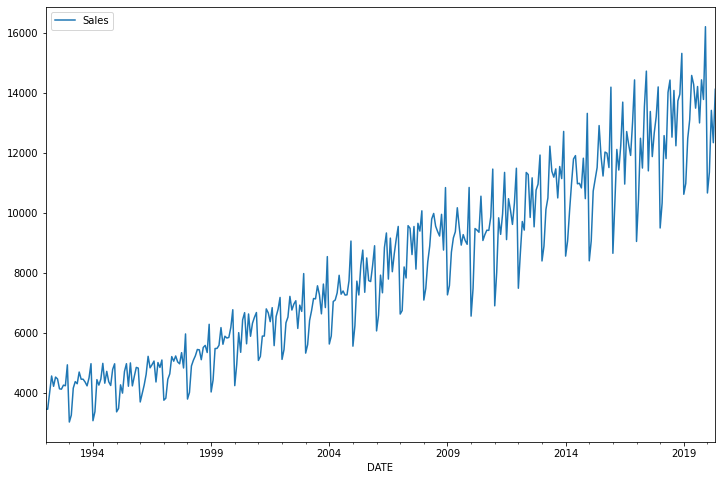

In [5]:
df.plot(figsize=(12,8))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


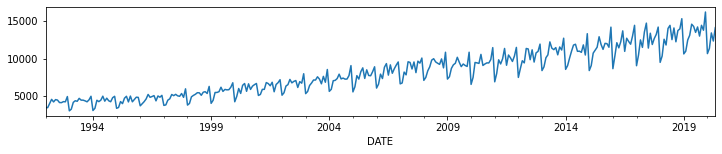

In [11]:
results = seasonal_decompose(df['Sales'])
results.observed.plot(figsize=(12,2))

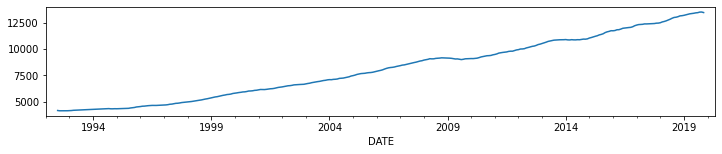

In [12]:
results.trend.plot(figsize=(12,2))

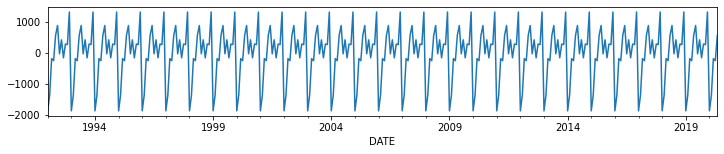

In [13]:
results.seasonal.plot(figsize=(12,2))

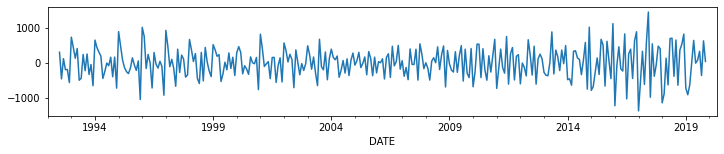

In [14]:
results.resid.plot(figsize=(12,2))

## Train Test Split

In [15]:
len(df)

341

In [16]:
len(df)-12 

329

In [17]:
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [18]:
len(test)

12

## Escalando los datos

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler()

In [21]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [22]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

Este generador toma una secuencia de puntos de datos (como una sereie temporal) espaciados en intervalos iguales, teniendo en cuenta otros parámetros de series temporales, para producir batches para el entrenamiento / validación.

#### Argumentos
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [23]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [24]:
scaled_train

array([[0.03486194],
       [0.03478048],
       [0.07909098],
       [0.12486764],
       [0.09692922],
       [0.12201678],
       [0.11688523],
       [0.09008715],
       [0.08919117],
       [0.10002444],
       [0.09847683],
       [0.1551682 ],
       [0.        ],
       [0.01873422],
       [0.09196058],
       [0.1096359 ],
       [0.10393419],
       [0.13561945],
       [0.11623361],
       [0.11615215],
       [0.10857701],
       [0.09815101],
       [0.11965464],
       [0.15826342],
       [0.00358394],
       [0.02818278],
       [0.11501181],
       [0.10018734],
       [0.11639651],
       [0.1591594 ],
       [0.10531889],
       [0.13749287],
       [0.10939155],
       [0.09912845],
       [0.14278733],
       [0.15801906],
       [0.02761261],
       [0.03689827],
       [0.10083897],
       [0.07843936],
       [0.13716706],
       [0.15826342],
       [0.09709212],
       [0.1603812 ],
       [0.09806956],
       [0.12405311],
       [0.14824469],
       [0.146

In [53]:
# Definimos el generator (here we have targets as data train)
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=n_features)

In [54]:
len(scaled_train)

329

In [55]:
len(generator) # n_input = 2

327

In [56]:
scaled_train[:5]

array([[0.03486194],
       [0.03478048],
       [0.07909098],
       [0.12486764],
       [0.09692922]])

In [57]:
# ¿Cómo luce el primer batch?
generator[0]

(array([[[0.03486194],
         [0.03478048]]]), array([[0.07909098]]))

In [58]:
X,y = generator[0]

In [59]:
print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')

Datos: 
[0.03486194 0.03478048]
Predicción: 
 [[0.07909098]]


In [60]:
# Vamos a redefinir para que utilice 12 meses y luego prediga el próximo mes
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [34]:
# ¿Cómo luce el primer batch?
X,y = generator[0]

In [35]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03486194 0.03478048 0.07909098 0.12486764 0.09692922 0.12201678
 0.11688523 0.09008715 0.08919117 0.10002444 0.09847683 0.1551682 ]
Predict this y: 
 [[0.]]


### Creando el Modelo

In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [37]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [39]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50
317/317 [==============================] - 2s 7ms/step - loss: 0.0154
Epoch 2/50
317/317 [==============================] - 2s 5ms/step - loss: 0.0082
Epoch 3/50
317/317 [==============================] - 2s 5ms/step - loss: 0.0097
Epoch 4/50
317/317 [==============================] - 2s 5ms/step - loss: 0.0078
Epoch 5/50
317/317 [==============================] - 2s 5ms/step - loss: 0.0068
Epoch 6/50
317/317 [==============================] - 2s 5ms/step - loss: 0.0052
Epoch 7/50
317/317 [==============================] - 2s 5ms/step - loss: 0.0042
Epoch 8/50
317/317 [==============================] - 2s 5ms/step - loss: 0.0036
Epoch 9/50
317/317 [==============================] - 2s 5ms/step - loss: 0.0034
Epoch 10/50
317/317 [==============================] - 2s 5ms/step - loss: 0.0024
Epoch 11/50
317/317 [==============================] - 2s 5ms/step - loss: 0.0025
Epoch 12/50
317/317 [==============================] - 2s 5ms/step - loss: 0.0021
Epoch 13/50
317/317 [====

In [48]:
model.history.history.keys()

dict_keys(['loss'])

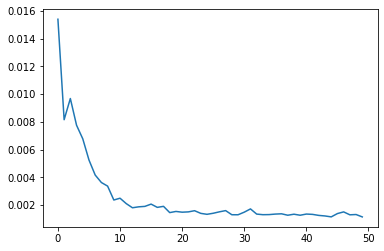

In [49]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluando en los Datos de Prueba (Test)

In [63]:
# 12 meses de historia ---> predecir el 13
# Necesitaremos los últimos 12 meses del conjunto de entrenamiento para predecir el 1er mes en el conjunto de prueba
first_eval_batch = scaled_train[-12:]

In [64]:
first_eval_batch

array([[0.92766963],
       [0.77274578],
       [0.89940539],
       [0.74936874],
       [0.87122261],
       [0.8893052 ],
       [1.        ],
       [0.61782194],
       [0.64714507],
       [0.76899894],
       [0.8199886 ],
       [0.94013195]])

In [65]:
X.shape

(1, 2, 1)

In [66]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [67]:
first_eval_batch.shape

(1, 12, 1)

In [68]:
model.predict(first_eval_batch) #output will be the first value of scaled test

array([[0.9449047]], dtype=float32)

In [70]:
scaled_test

array([[0.91602183],
       [0.8514295 ],
       [0.9101572 ],
       [0.81135457],
       [0.9282398 ],
       [0.87496946],
       [1.07241183],
       [0.62132443],
       [0.67760854],
       [0.84540197],
       [0.75775841],
       [0.90250061]])

Ahora pongamos esta lógica en un bucle for para predecir el futuro para todo el rango de prueba.
----

In [71]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [72]:
test_predictions

[array([0.9449047], dtype=float32),
 array([0.8139729], dtype=float32),
 array([0.92430264], dtype=float32),
 array([0.7865002], dtype=float32),
 array([0.9022329], dtype=float32),
 array([0.92182416], dtype=float32),
 array([1.0246984], dtype=float32),
 array([0.6365804], dtype=float32),
 array([0.6987433], dtype=float32),
 array([0.79493535], dtype=float32),
 array([0.8653643], dtype=float32),
 array([0.95792437], dtype=float32)]

In [73]:
scaled_test

array([[0.91602183],
       [0.8514295 ],
       [0.9101572 ],
       [0.81135457],
       [0.9282398 ],
       [0.87496946],
       [1.07241183],
       [0.62132443],
       [0.67760854],
       [0.84540197],
       [0.75775841],
       [0.90250061]])

## Transformación inversa y Comparación

In [74]:
true_predictions = scaler.inverse_transform(test_predictions)

In [75]:
true_predictions

array([[14631.594818  ],
       [13024.14517516],
       [14378.66348153],
       [12686.86314607],
       [14107.71313357],
       [14348.23517841],
       [15611.2219702 ],
       [10846.29766434],
       [11609.47129458],
       [12790.42123854],
       [13655.07767224],
       [14791.43744135]])

In [76]:
test

,Sales
DATE,
2019-06-01,14277
2019-07-01,13484
2019-08-01,14205
2019-09-01,12992
2019-10-01,14427
2019-11-01,13773
2019-12-01,16197
2020-01-01,10659
2020-02-01,11350


In [77]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
test

,Sales,Predictions
DATE,,
2019-06-01,14277,14631.594818
2019-07-01,13484,13024.145175
2019-08-01,14205,14378.663482
2019-09-01,12992,12686.863146
2019-10-01,14427,14107.713134
2019-11-01,13773,14348.235178
2019-12-01,16197,15611.221970
2020-01-01,10659,10846.297664
2020-02-01,11350,11609.471295


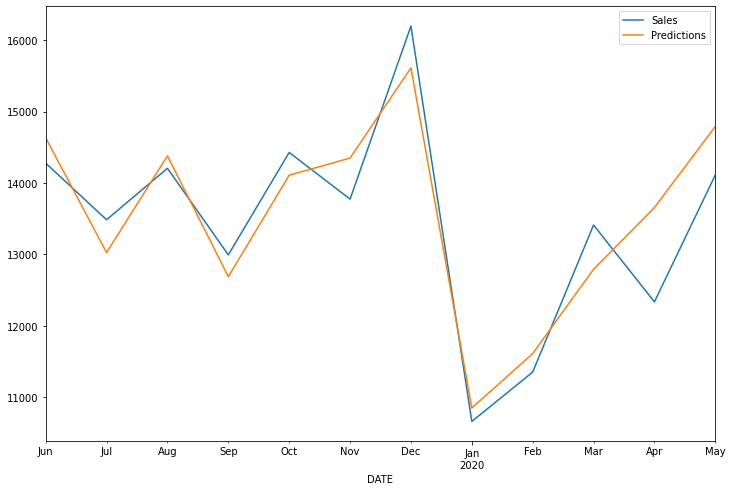

In [79]:
test.plot(figsize=(12,8))

# Guardar un Modelo

In [ ]:
model.save('my_rnn_model.h5')

# Cargar un Modelo

In [ ]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')

In [ ]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
